In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import polars as pl
import sklearn

In [ ]:
# Filepath of data
filepath = "./9417_imputed_data"

# Train and Test Splits
trainsplit = 6043
testsplit = 7110

np.random.seed(777)

#### Importing Data

In [3]:
df_lag_base = pl.read_ipc(filepath + "/denormalised, with lags.parquet").to_pandas()
df_lag_01 = pl.read_ipc(filepath + "/min-max scaled, with lags.parquet").to_pandas()
df_lag_z = pl.read_ipc(filepath + "/Z-score normalised, with lags.parquet").to_pandas()
df_nolag_base = pl.read_ipc(filepath + "/denormalised, no lags.parquet").to_pandas()
df_nolag_01 = pl.read_ipc(filepath + "/min-max scaled, no lags.parquet").to_pandas()
df_nolag_z = pl.read_ipc(filepath + "/Z-score normalised, no lags.parquet").to_pandas()

#### Preparing Data

In [ ]:
# For L1 Lasso 
X1 = df_lag_z 
X1.drop(["DateTime", "Date", "Time"], axis="columns", inplace=True, errors="ignore")

X1_nontest = X1.iloc[:testsplit]
X1_train = X1_nontest.iloc[:trainsplit]
X1_validation = X1_nontest.iloc[trainsplit:]
X1_test = X1.iloc[testsplit:]

# For XGBoost
X2 = df_lag_01 
X2.columns = (
    X2.columns
    .str.replace("[", "", regex=False)
    .str.replace("]", "", regex=False)
    .str.replace("<", "", regex=False)
    .str.replace(">", "", regex=False)
)
X2.drop(["DateTime", "Date", "Time"], axis="columns", inplace=True, errors="ignore")

X2_nontest = X2.iloc[:testsplit]
X2_train = X2_nontest.iloc[:trainsplit]
X2_validation = X2_nontest.iloc[trainsplit:]
X2_test = X2.iloc[testsplit:]

In [5]:
y = []
for i in df_lag_base["CO(GT)"]:
    co = round(i,4)
    y.append(0 if co < 1.5 else 1 if co < 2.5 else 2)
y = pd.get_dummies(y, dtype=float)
y_nontest = y[:testsplit]
y_train = y_nontest.iloc[:trainsplit]
y_validation = y_nontest.iloc[trainsplit:]
y_test = y[testsplit:]

In [6]:
print(X1.shape, y.shape)
print(X1_nontest.shape, y_nontest.shape)
print(X1_train.shape, y_train.shape)
print(X1_validation.shape, y_validation.shape)
print(X1_test.shape, y_test.shape)

(9357, 312) (9357, 3)
(7110, 312) (7110, 3)
(6043, 312) (6043, 3)
(1067, 312) (1067, 3)
(2247, 312) (2247, 3)


In [ ]:
# Combining sets ready for training for both models
nontest_combined_1 = pd.concat([X1_nontest, y_nontest], axis=1)
train_combined_1 = pd.concat([X1_train, y_train], axis=1)
validation_combined_1 = pd.concat([X1_validation, y_validation], axis=1)
test_combined_1 = pd.concat([X1_test, y_test], axis=1)

nontest_combined_1 = nontest_combined_1.dropna()
train_combined_1 = train_combined_1.dropna()
validation_combined_1 = validation_combined_1.dropna()
test_combined_1 = test_combined_1.dropna()

y_nontest_1 = nontest_combined_1[[0, 1, 2]]
X_nontest_1 = nontest_combined_1.drop([0, 1, 2], axis="columns", errors="ignore")
y_train_1 = train_combined_1[[0, 1, 2]]
X_train_1 = train_combined_1.drop([0, 1, 2], axis="columns", errors="ignore")
y_validation_1 = validation_combined_1[[0, 1, 2]]
X_validation_1 = validation_combined_1.drop([0, 1, 2], axis="columns", errors="ignore")
y_test_1 = test_combined_1[[0, 1, 2]]
X_test_1 = test_combined_1.drop([0, 1, 2], axis="columns", errors="ignore")

nontest_combined_2 = pd.concat([X2_nontest, y_nontest], axis=1)
train_combined_2 = pd.concat([X2_train, y_train], axis=1)
validation_combined_2 = pd.concat([X2_validation, y_validation], axis=1)
test_combined_2 = pd.concat([X2_test, y_test], axis=1)

nontest_combined_2 = nontest_combined_2.dropna()
train_combined_2 = train_combined_2.dropna()
validation_combined_2 = validation_combined_2.dropna()
test_combined_2 = test_combined_2.dropna()

y_nontest_2 = nontest_combined_2[[0, 1, 2]]
X_nontest_2 = nontest_combined_2.drop([0, 1, 2], axis="columns", errors="ignore")
y_train_2 = train_combined_2[[0, 1, 2]]
X_train_2 = train_combined_2.drop([0, 1, 2], axis="columns", errors="ignore")
y_validation_2 = validation_combined_2[[0, 1, 2]]
X_validation_2 = validation_combined_2.drop([0, 1, 2], axis="columns", errors="ignore")
y_test_2 = test_combined_2[[0, 1, 2]]
X_test_2 = test_combined_2.drop([0, 1, 2], axis="columns", errors="ignore")

In [8]:
print(X1_nontest.shape, y_nontest.shape)
print(X1_train.shape, y_train.shape)
print(X1_validation.shape, y_validation.shape)
print(X1_test.shape, y_test.shape)

(7110, 312) (7110, 3)
(6043, 312) (6043, 3)
(1067, 312) (1067, 3)
(2247, 312) (2247, 3)


#### Testing and Evaluation Functions

In [ ]:
# Plots Confusion Matrix
def confusion_and_graph(t, n_test, y_true, y_predicted, method): 
    y_true = np.array(y_true)
    y_predicted = np.array(y_predicted)
    y_predicted = np.array(y_predicted)

    correct = (y_true == y_predicted).sum()
    accuracy = correct / n_test * 100
    
    print(f"total={n_test}", f"correct={correct}", f"{method} accuracy={accuracy:.2f}%")

    print("confusion matrix (vertical axis=true, horizontal=predicted):")
    conf_mat = sklearn.metrics.confusion_matrix(y_true, y_predicted, labels = [0, 1, 2])
    print(conf_mat)
    
    limited = min(n_test, 100)
    hour = range(limited)
    plt.plot(hour, y_true[:limited], label="True", color="blue", linestyle="-")
    plt.plot(hour, y_predicted[:limited], label="Predicted", color="red", linestyle="-")
    plt.xlabel("Hours")
    plt.ylabel("CO Classification")
    plt.title(f"{method} CO Predictions t={t}")
    plt.legend()
    plt.show()

In [ ]:
# Compares against baseline/naive/no change
def compare_baseline(t, n_test):
    print(f"Compared against baseline naive t={t}:")
    y_baseline = np.array(y_nontest.iloc[-(n_test + t):], dtype=np.float32).argmax(axis = 1)
    print(np.unique(y_baseline, return_counts=True))
    print()

    y_true = y_baseline[t:]
    y_predicted = y_baseline[:-t]

    confusion_and_graph(t, n_test, y_true, y_predicted, "naive")

In [ ]:
# Tests model against true value
def test_model(model, X_test, y_test, method):
    y_true = np.array(y_test).argmax(axis = 1)
    y_predicted = model.predict(X_test)
    
    model_accuracy = sklearn.metrics.accuracy_score(y_true, y_predicted) * 100
    print(f"{method} test {model_accuracy:.2f}%")
    
    return model_accuracy

In [ ]:
# Tests temporal predictions
def t_temporal_prediction(model, t, test_proportion, X_nontest, y_nontest, method):
    X_t_shifted = X_nontest.iloc[:-t]
    y_t_shifted = y_nontest.iloc[t:]
    n_total = X_t_shifted.shape[0]
    n_train = int(n_total * (1 - test_proportion))
    n_test = n_total - n_train

    X_train = np.array(X_t_shifted[:n_train], dtype=np.float32)
    y_train = np.array(y_t_shifted[:n_train], dtype=np.float32)
    X_valid = np.array(X_t_shifted[n_train:], dtype=np.float32)
    y_valid = np.array(y_t_shifted[n_train:], dtype=np.float32)

    model.fit(X_train, y_train.argmax(axis=1))
    y_predicted = model.predict(X_valid)

    print(f"{method} Model performance t={t}")
    confusion_and_graph(t, n_test, y_valid.argmax(axis=1), y_predicted, method)
    compare_baseline(t, n_test)

In [ ]:
# Plots shap_graph
def shap_graph(model, X_test, X_nontest, name):

    background_np = np.array(X_nontest.sample(100, random_state=42), dtype=np.float32)
    explain_np = np.array(X_test.sample(500, random_state=42), dtype=np.float32)

    if name == "XGBoost":
        explainer = shap.TreeExplainer(model, background_np)
    else:
        predict_func = lambda x: model.predict_proba(x)
        explainer = shap.KernelExplainer(predict_func, background_np)
    shap_values_raw = explainer.shap_values(explain_np)
    shap_values_by_class = [shap_values_raw[:, :, i] for i in range(3)]

    for class_id, shap_values in enumerate(shap_values_by_class):
        plt.title(f"SHAP: feature impacts for class={class_id} - {name}")
        shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)
    return shap_values_raw

#### Hyperparameter Testing

In [14]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

random_state = 777

In [ ]:
# Hyperparameter optimisation for logistic
log_l1 = LogisticRegression(
    penalty="l1",
    solver='saga',
    max_iter=5000,
    class_weight="balanced",
    random_state=random_state
)

params = {
    "C": [0.04, 0.05, 0.06]
}

search = GridSearchCV(
    estimator=log_l1,
    param_grid=params,
    scoring="accuracy",
    cv=[(np.arange(len(X_train_1)), np.arange(len(X_train_1), len(X_train_1) + len(X_validation_1)))],
    verbose=1
)

search.fit(X_nontest_1, y_nontest_1.to_numpy().argmax(axis=1))

print("Best L1 Logistic Regression Params:", search.best_params_)
print("Best Validation Accuracy:", search.best_score_)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
Best L1 Logistic Regression Params: {'C': 0.04}
Best Validation Accuracy: 0.9943767572633552


In [ ]:
# Hyperparameter optimisation for xgb
xgb = XGBClassifier(objective="multi:softprob", 
                    num_class=3, 
                    eval_metric="mlogloss",
                    n_jobs=-1, 
                    random_state=random_state)

params = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3],
    "learning_rate": [0.005],
    "subsample": [0.2],
    "colsample_bytree": [0.5],
    "gamma": [0.05]
}

scorer = make_scorer(accuracy_score)

search = GridSearchCV(
    xgb,
    param_grid=params,
    scoring=scorer,
    cv=[(np.arange(len(X_train_2)), np.arange(len(X_train_2), len(X_train_2) + len(X_validation_2)))],
    verbose=2,
)

search.fit(X_nontest_2, y_nontest_2.to_numpy().argmax(axis=1))
print("Best XGB params:", search.best_params_)
print("Best XGB accuracy:", search.best_score_)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] END colsample_bytree=0.5, gamma=0.05, learning_rate=0.005, max_depth=3, n_estimators=100, subsample=0.2; total time=   8.4s
[CV] END colsample_bytree=0.5, gamma=0.05, learning_rate=0.005, max_depth=3, n_estimators=300, subsample=0.2; total time=  20.7s
[CV] END colsample_bytree=0.5, gamma=0.05, learning_rate=0.005, max_depth=3, n_estimators=500, subsample=0.2; total time=  34.6s
Best XGB params: {'colsample_bytree': 0.5, 'gamma': 0.05, 'learning_rate': 0.005, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.2}
Best XGB accuracy: 0.9990627928772259


#### Model Results

In [17]:
### Final Models
best_logistic = LogisticRegression(
    penalty='l1',
    solver='saga',
    C=0.04,
    max_iter=5000,
    random_state=random_state
)

best_logistic.fit(X_nontest_1, y_nontest_1.to_numpy().argmax(axis=1))

best_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.005,
    subsample=0.2,
    colsample_bytree=0.5,
    gamma=0.05,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    random_state=random_state
)

best_xgb.fit(X_nontest_2, y_nontest_2.to_numpy().argmax(axis=1))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.05,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=3, ...)

In [18]:
test_proportion = 0.15

Logistic LASSO Model performance t=1
total=991 correct=742 Logistic LASSO accuracy=74.87%
confusion matrix (vertical axis=true, horizontal=predicted):
[[235  61  11]
 [ 31 105 106]
 [  4  36 402]]


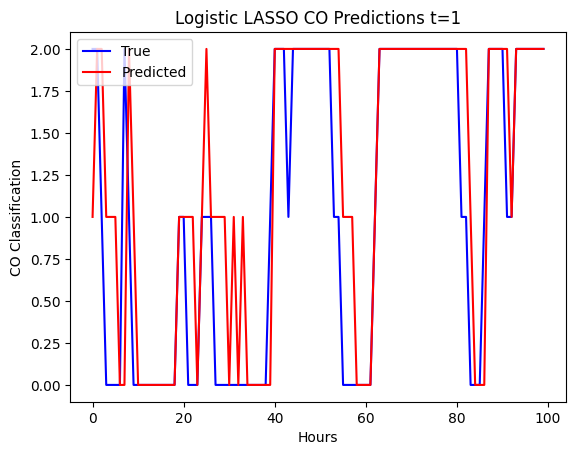

Compared against baseline naive t=1:
(array([0, 1, 2]), array([307, 243, 442]))

total=991 correct=770 naive accuracy=77.70%
confusion matrix (vertical axis=true, horizontal=predicted):
[[256  49   2]
 [ 40 138  64]
 [ 10  56 376]]


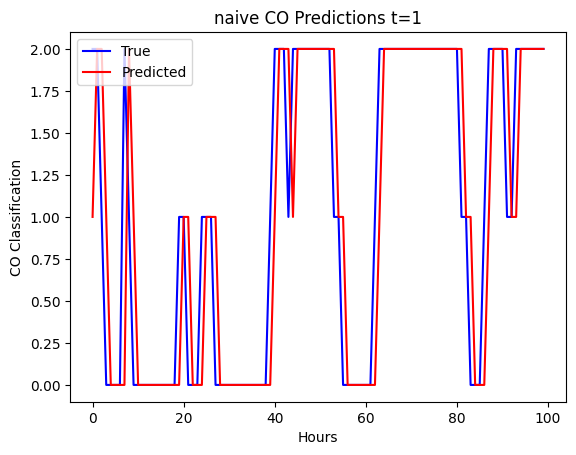

XGBoost Model performance t=1
total=991 correct=761 XGBoost accuracy=76.79%
confusion matrix (vertical axis=true, horizontal=predicted):
[[268  35   4]
 [ 55 146  41]
 [  9  86 347]]


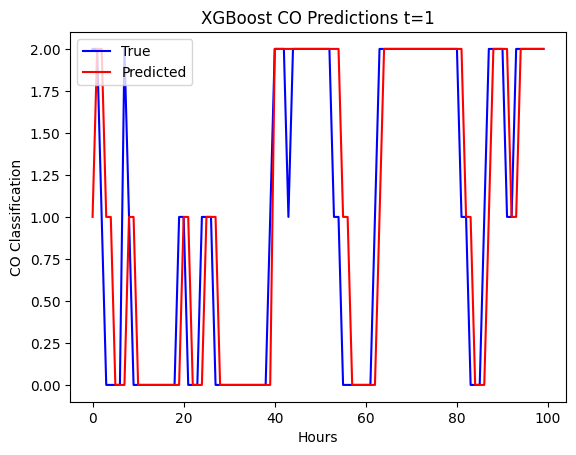

Compared against baseline naive t=1:
(array([0, 1, 2]), array([307, 243, 442]))

total=991 correct=770 naive accuracy=77.70%
confusion matrix (vertical axis=true, horizontal=predicted):
[[256  49   2]
 [ 40 138  64]
 [ 10  56 376]]


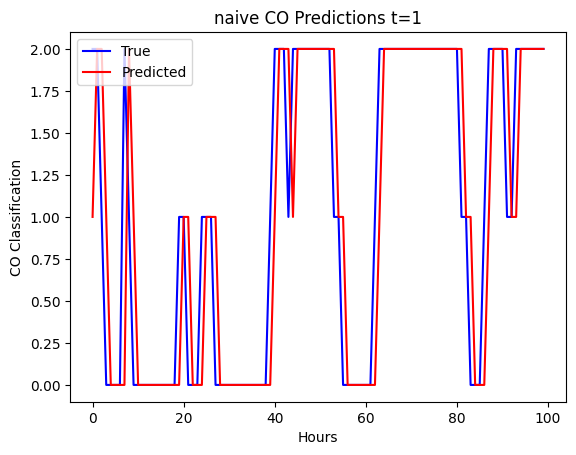

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


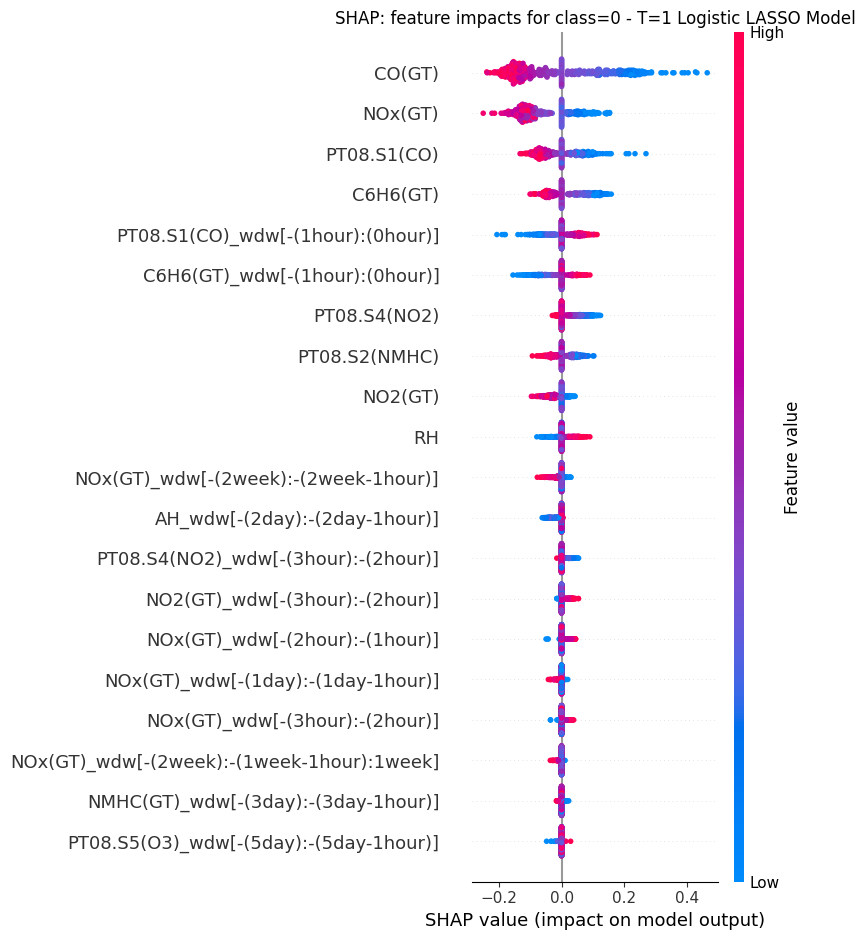

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


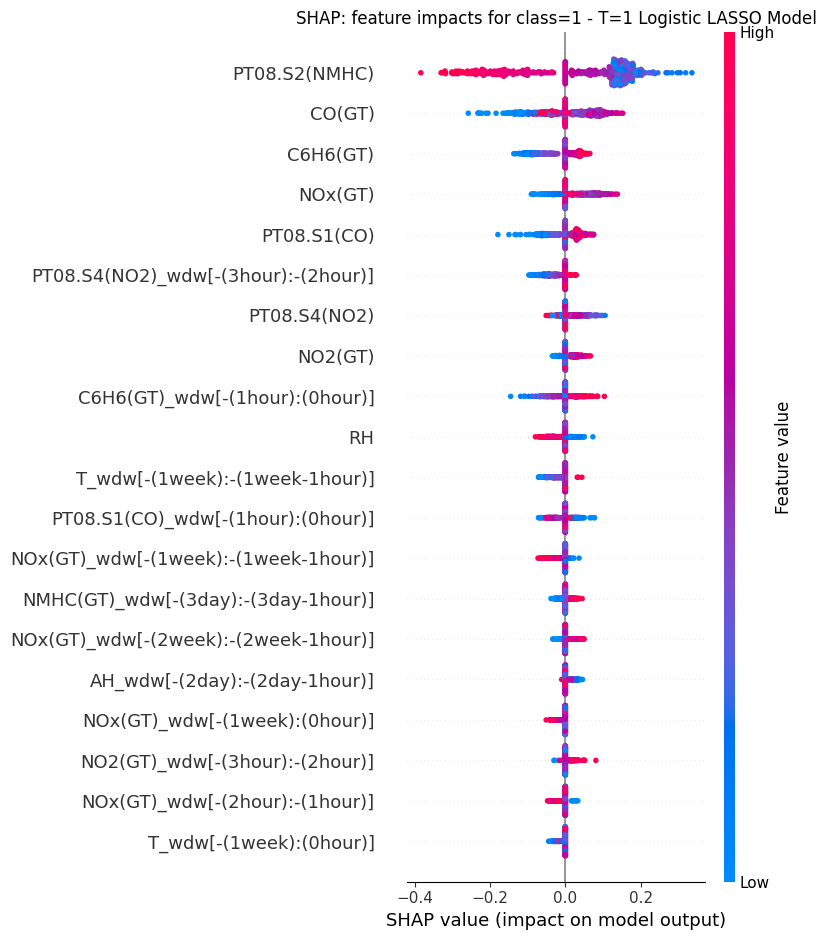

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


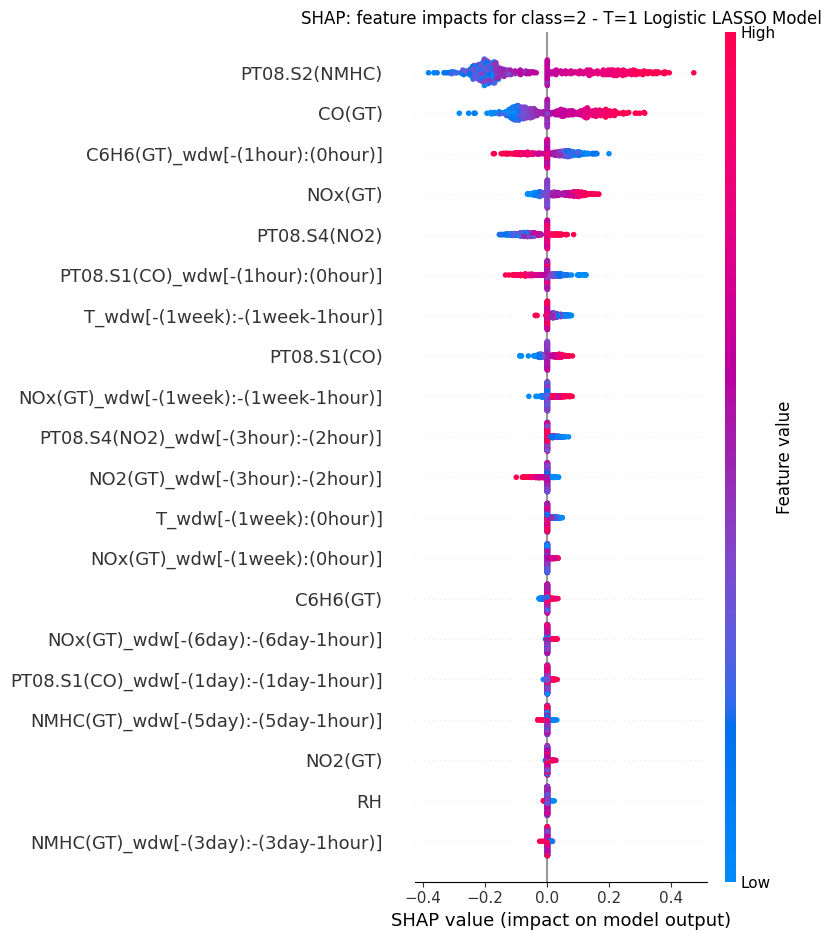

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


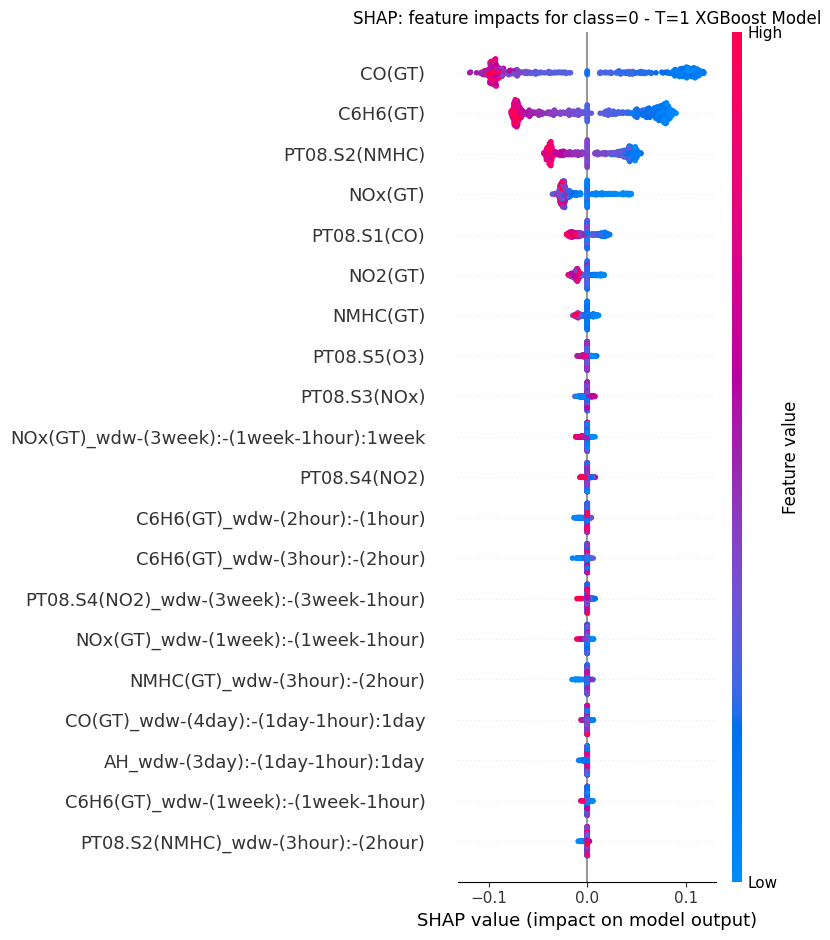

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


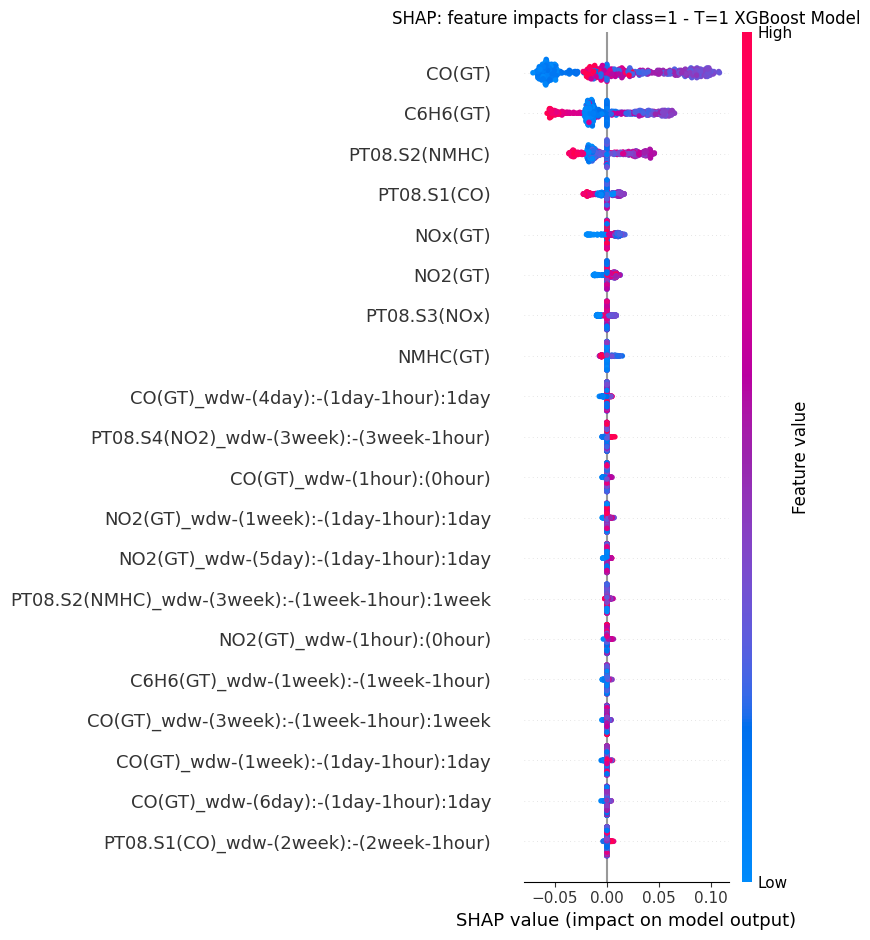

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


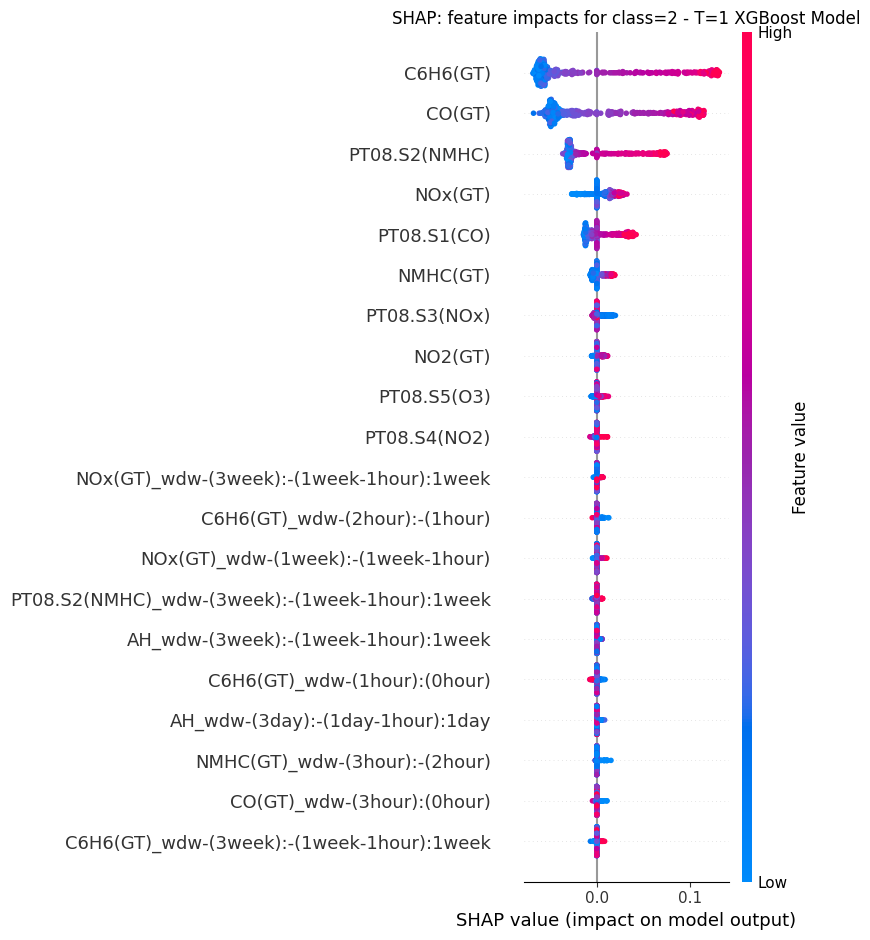

In [ ]:
# Testing on time horizon 1
t = 1
t_temporal_prediction(best_logistic, t, test_proportion, X_nontest_1, y_nontest_1, "Logistic LASSO")
t_temporal_prediction(best_xgb, t, test_proportion, X_nontest_2, y_nontest_2, "XGBoost")
shap_values_log_1 = shap_graph(best_logistic, X_test_1, X_nontest_1, f"T={t} Logistic LASSO Model")
shap_values_xgb_1 = shap_graph(best_xgb, X_test_2, X_nontest_2, f"T={t} XGBoost Model")

Logistic LASSO Model performance t=6
total=990 correct=551 Logistic LASSO accuracy=55.66%
confusion matrix (vertical axis=true, horizontal=predicted):
[[190   6 111]
 [110   4 128]
 [ 78   6 357]]


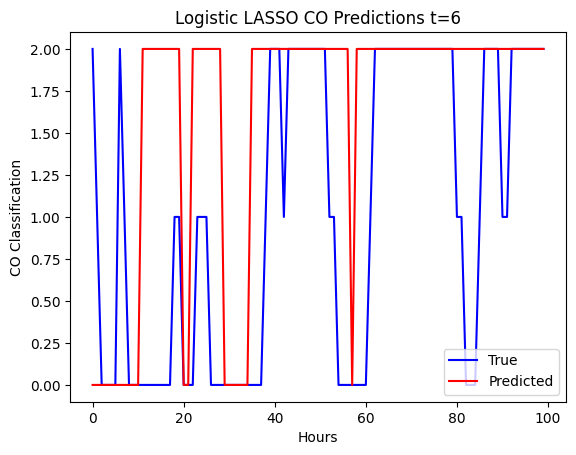

Compared against baseline naive t=6:
(array([0, 1, 2]), array([307, 247, 442]))

total=990 correct=431 naive accuracy=43.54%
confusion matrix (vertical axis=true, horizontal=predicted):
[[133  99  75]
 [ 71  51 120]
 [ 97  97 247]]


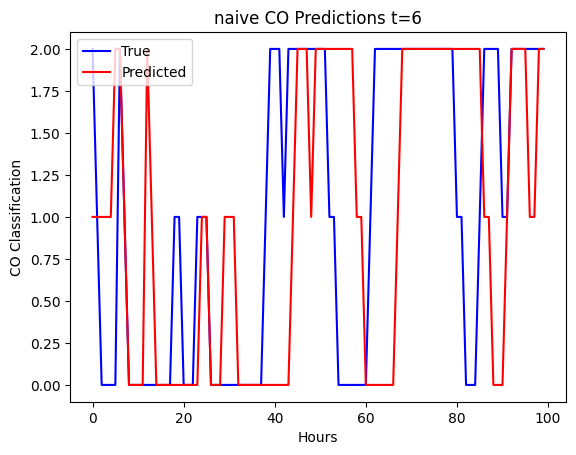

XGBoost Model performance t=6
total=990 correct=546 XGBoost accuracy=55.15%
confusion matrix (vertical axis=true, horizontal=predicted):
[[226   4  77]
 [130   5 107]
 [121   5 315]]


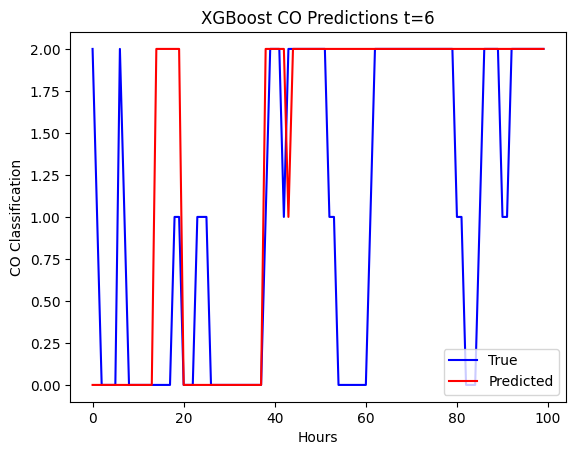

Compared against baseline naive t=6:
(array([0, 1, 2]), array([307, 247, 442]))

total=990 correct=431 naive accuracy=43.54%
confusion matrix (vertical axis=true, horizontal=predicted):
[[133  99  75]
 [ 71  51 120]
 [ 97  97 247]]


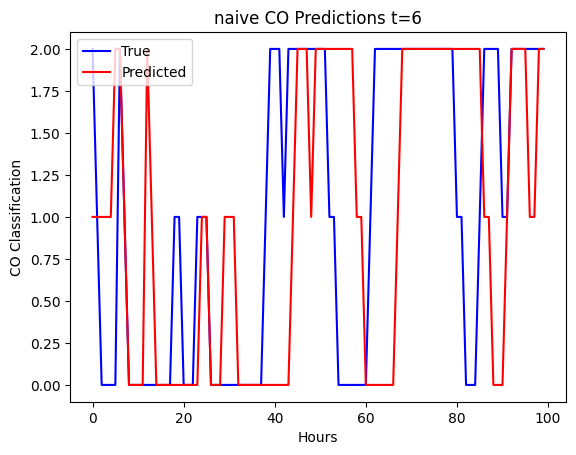

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


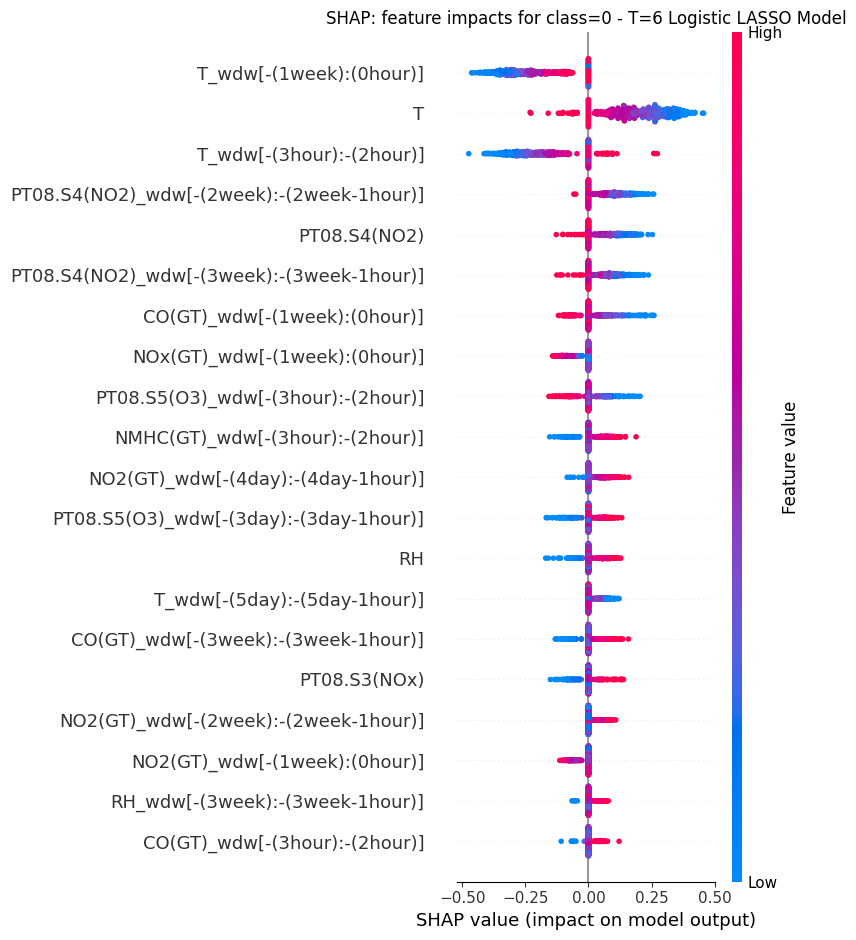

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


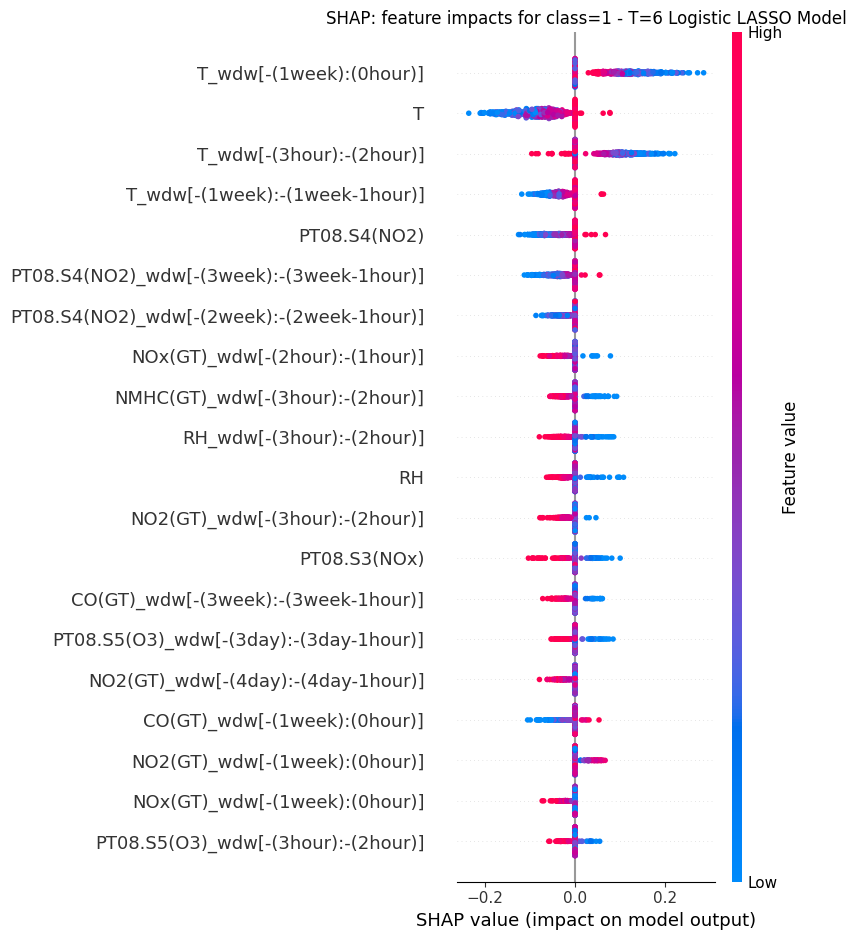

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


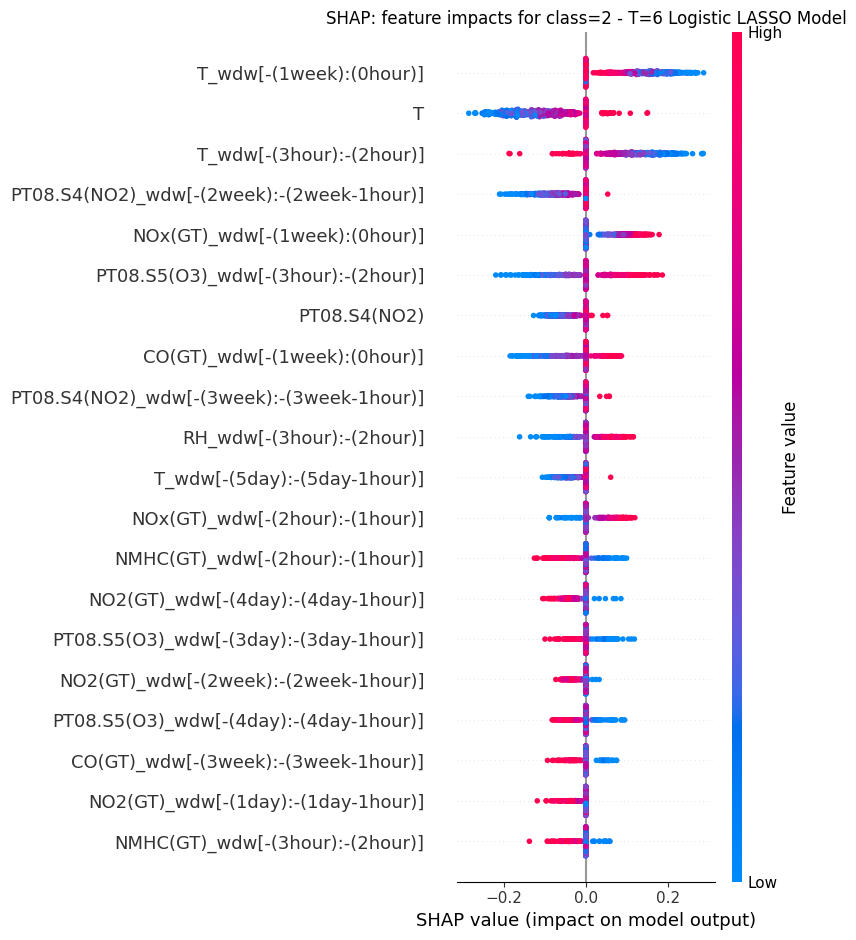

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


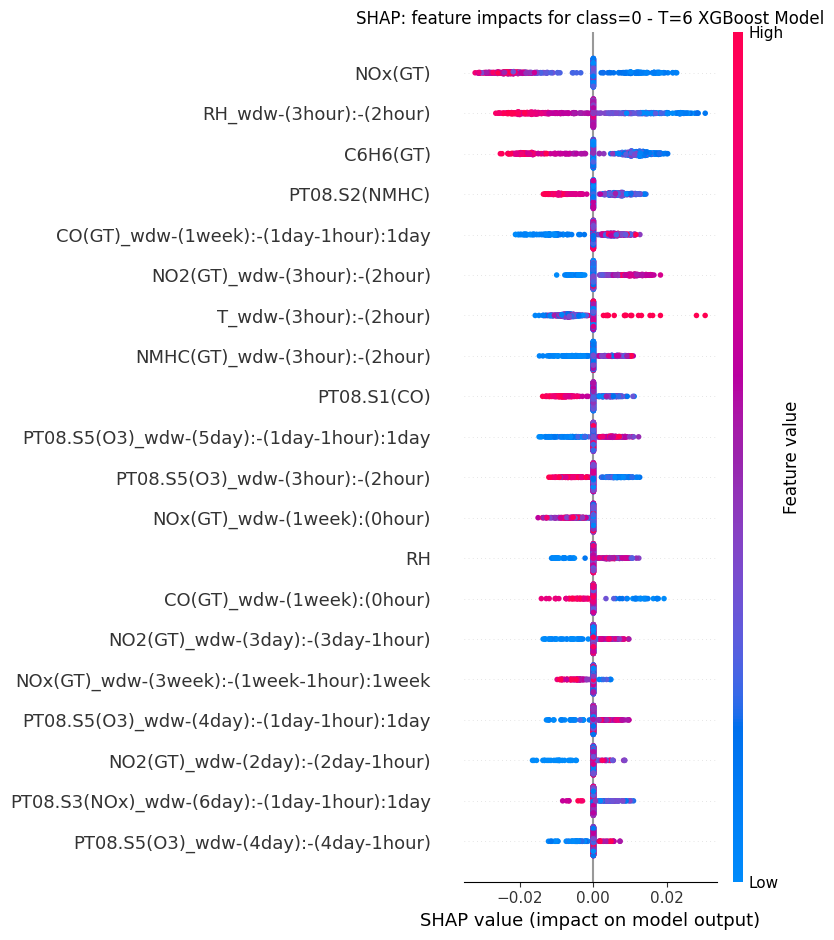

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


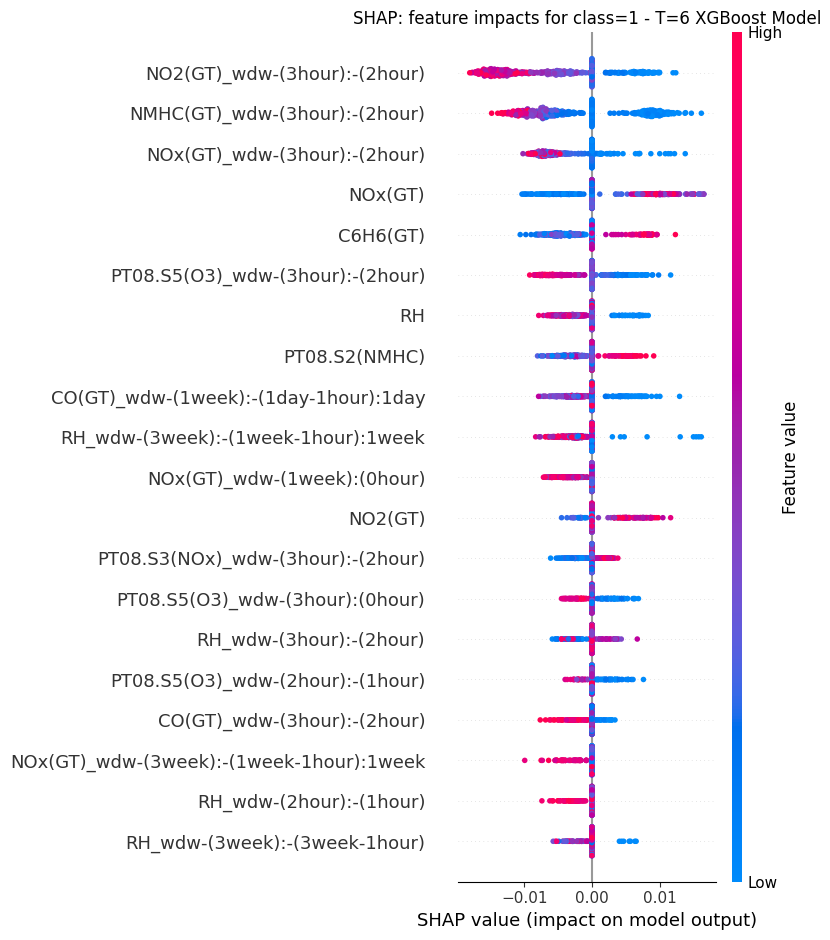

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


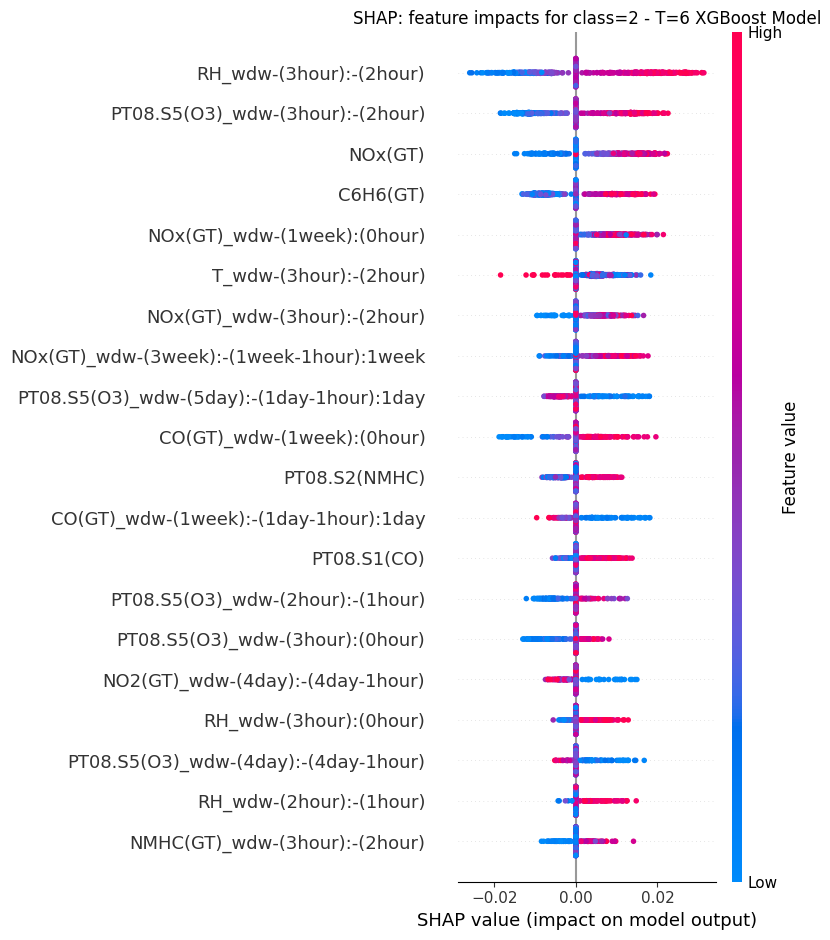

In [20]:
# Testing on time horizon 6
t = 6
t_temporal_prediction(best_logistic, t, test_proportion, X_nontest_1, y_nontest_1, "Logistic LASSO")
t_temporal_prediction(best_xgb, t, test_proportion, X_nontest_2, y_nontest_2, "XGBoost")
shap_values_log_6 = shap_graph(best_logistic, X_test_1, X_nontest_1, f"T={t} Logistic LASSO Model")
shap_values_xgb_6 = shap_graph(best_xgb, X_test_2, X_nontest_2, f"T={t} XGBoost Model")

Logistic LASSO Model performance t=12
total=990 correct=465 Logistic LASSO accuracy=46.97%
confusion matrix (vertical axis=true, horizontal=predicted):
[[ 70  21 216]
 [ 23  30 189]
 [ 23  53 365]]


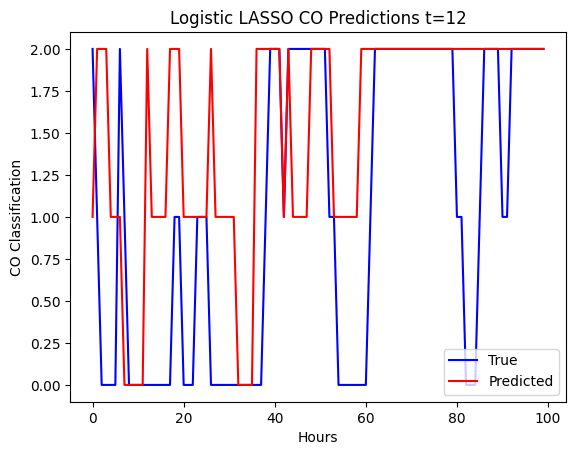

Compared against baseline naive t=12:
(array([0, 1, 2]), array([309, 249, 444]))

total=990 correct=350 naive accuracy=35.35%
confusion matrix (vertical axis=true, horizontal=predicted):
[[ 96  79 132]
 [ 70  57 115]
 [131 113 197]]


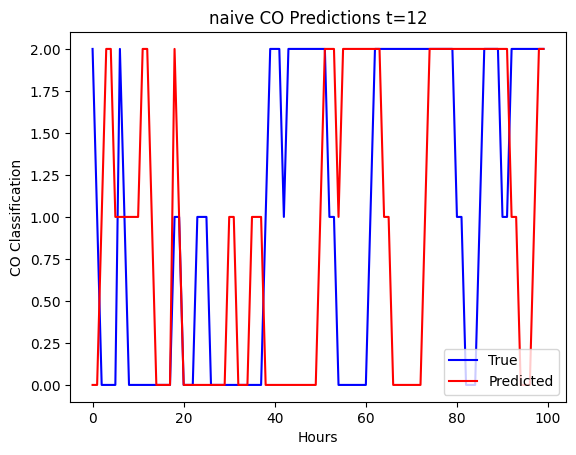

XGBoost Model performance t=12
total=990 correct=506 XGBoost accuracy=51.11%
confusion matrix (vertical axis=true, horizontal=predicted):
[[110   2 195]
 [ 44   4 194]
 [ 47   2 392]]


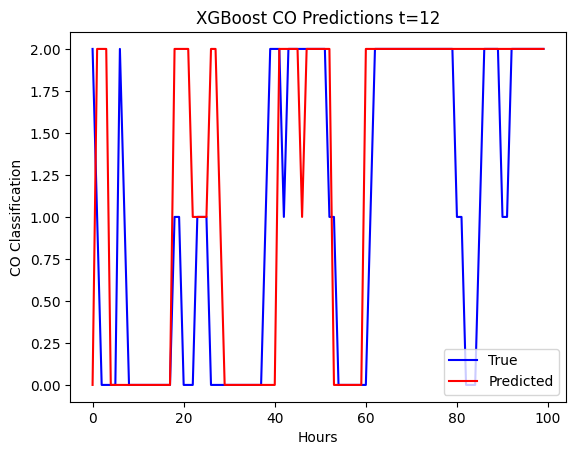

Compared against baseline naive t=12:
(array([0, 1, 2]), array([309, 249, 444]))

total=990 correct=350 naive accuracy=35.35%
confusion matrix (vertical axis=true, horizontal=predicted):
[[ 96  79 132]
 [ 70  57 115]
 [131 113 197]]


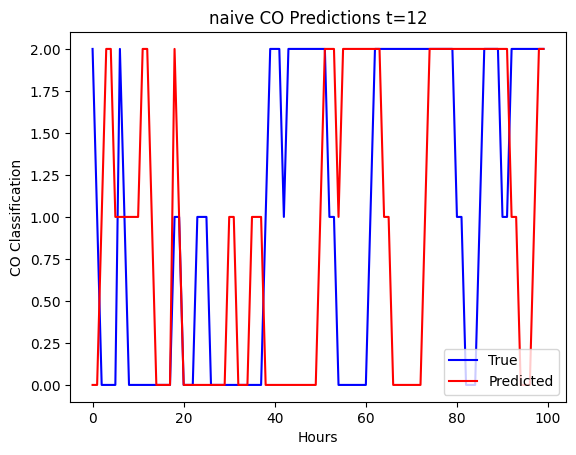

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


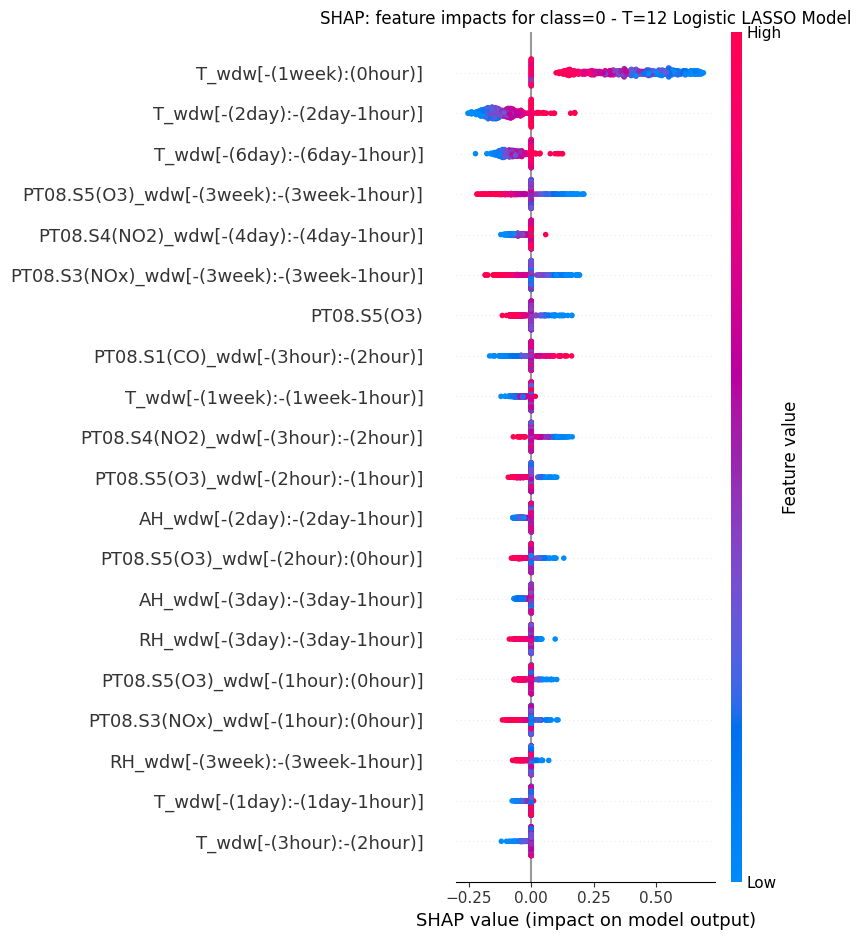

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


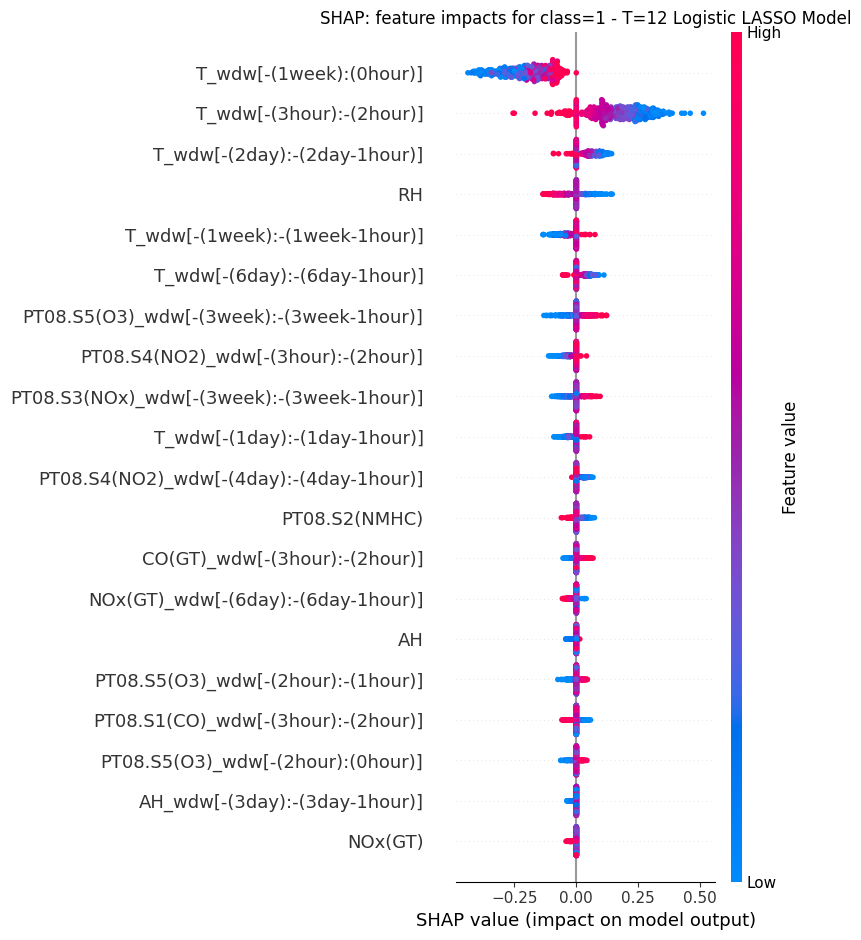

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


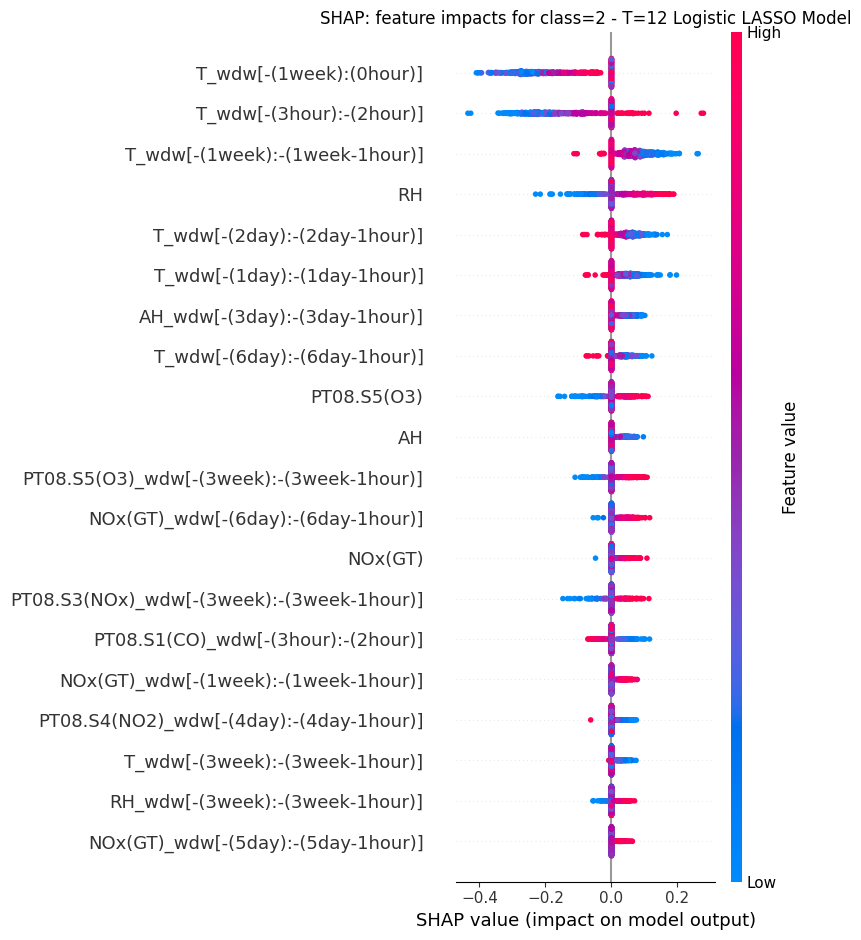

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


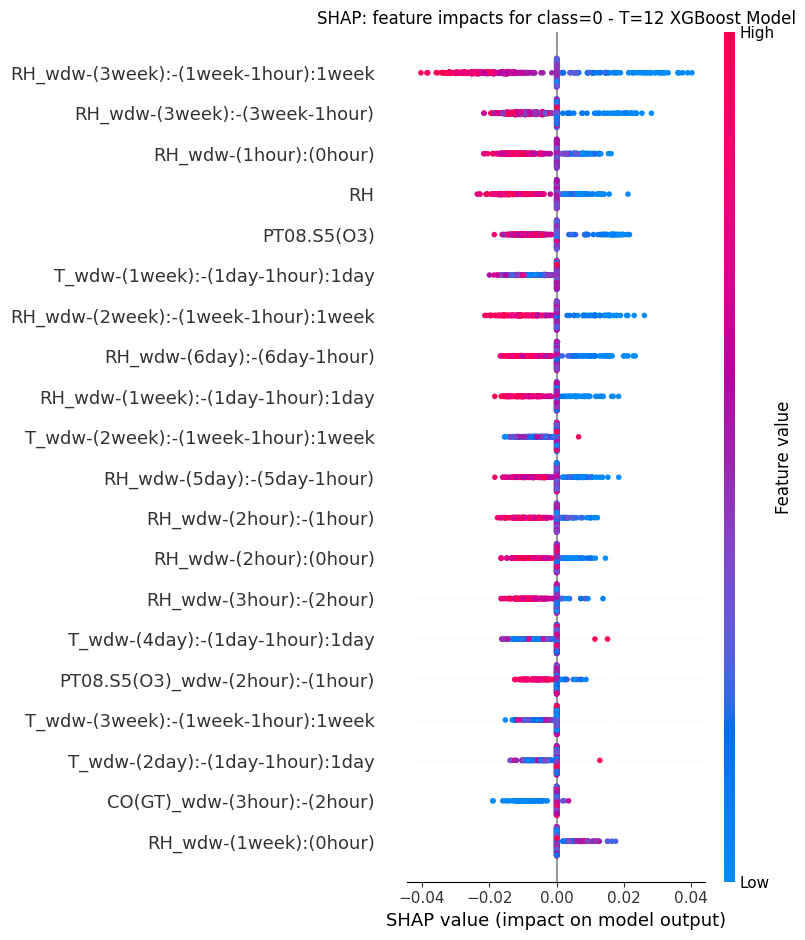

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


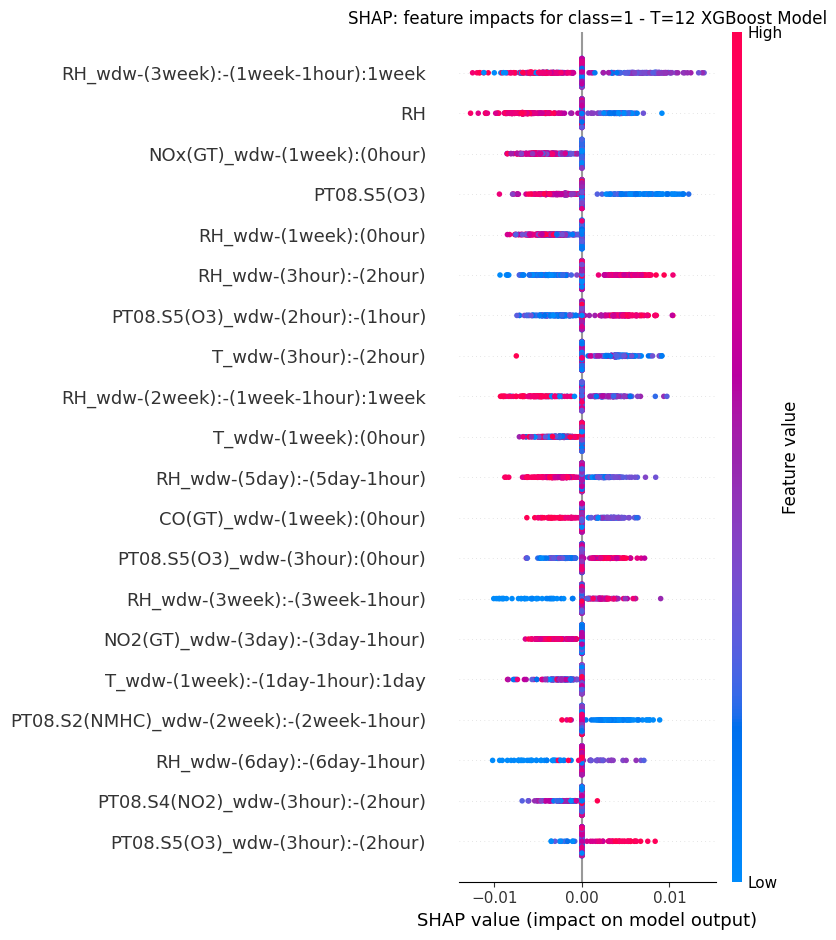

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\3784578741.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


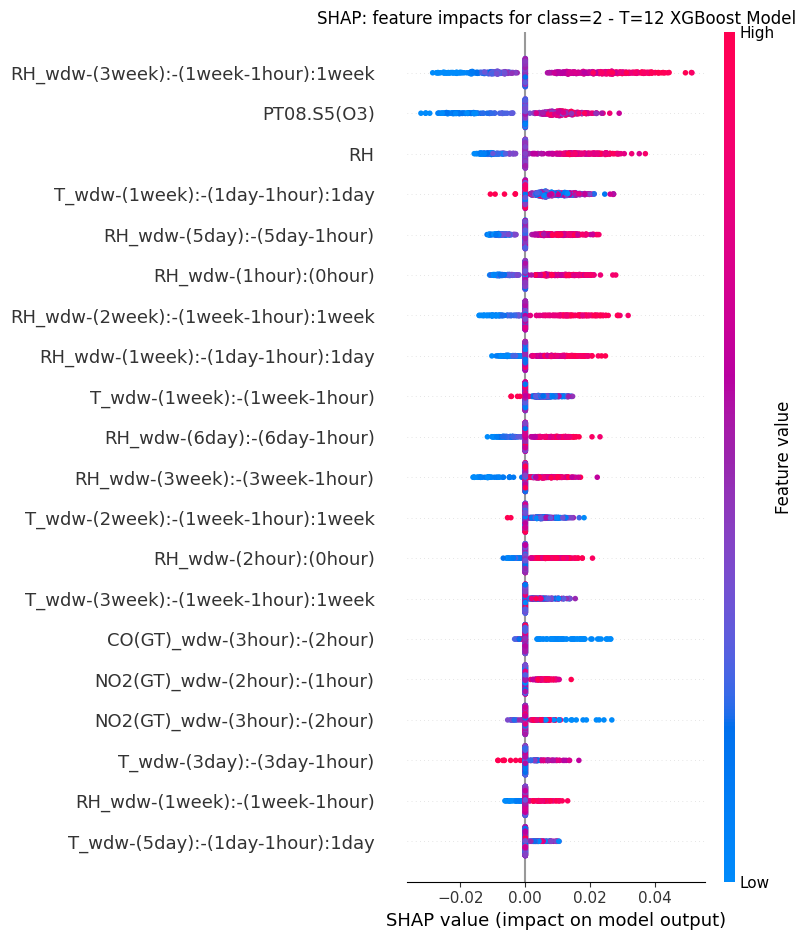

In [21]:
# Testing on time horizon 12
t = 12
t_temporal_prediction(best_logistic, t, test_proportion, X_nontest_1, y_nontest_1, "Logistic LASSO")
t_temporal_prediction(best_xgb, t, test_proportion, X_nontest_2, y_nontest_2, "XGBoost")
shap_values_log_12 = shap_graph(best_logistic, X_test_1, X_nontest_1, f"T={t} Logistic LASSO Model")
shap_values_xgb_12 = shap_graph(best_xgb, X_test_2, X_nontest_2, f"T={t} XGBoost Model")

Logistic LASSO Model performance t=24
total=988 correct=591 Logistic LASSO accuracy=59.82%
confusion matrix (vertical axis=true, horizontal=predicted):
[[173  23 111]
 [ 56  38 147]
 [ 14  46 380]]


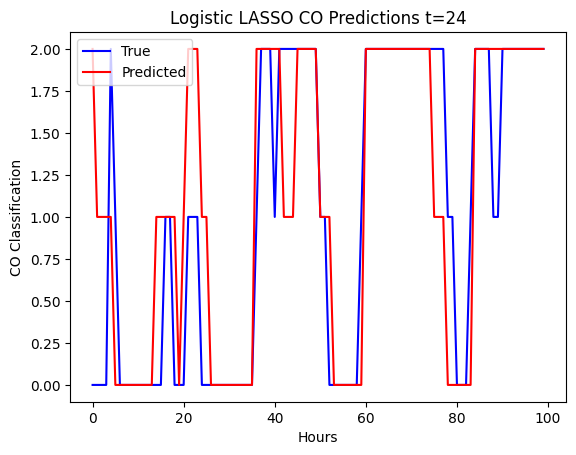

Compared against baseline naive t=24:
(array([0, 1, 2]), array([311, 250, 451]))

total=988 correct=567 naive accuracy=57.39%
confusion matrix (vertical axis=true, horizontal=predicted):
[[185  64  58]
 [ 66  82  93]
 [ 36 104 300]]


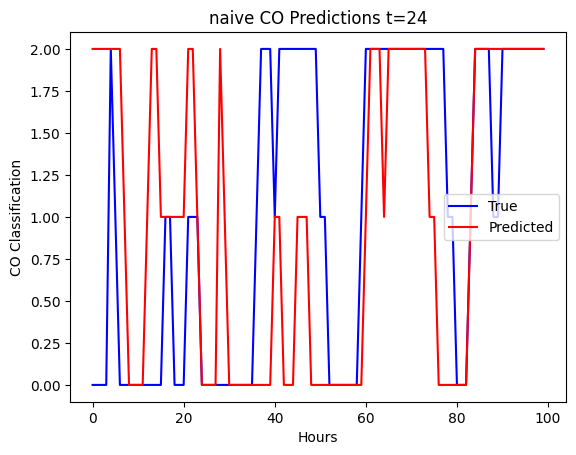

XGBoost Model performance t=24
total=988 correct=608 XGBoost accuracy=61.54%
confusion matrix (vertical axis=true, horizontal=predicted):
[[178  30  99]
 [ 57  37 147]
 [ 17  30 393]]


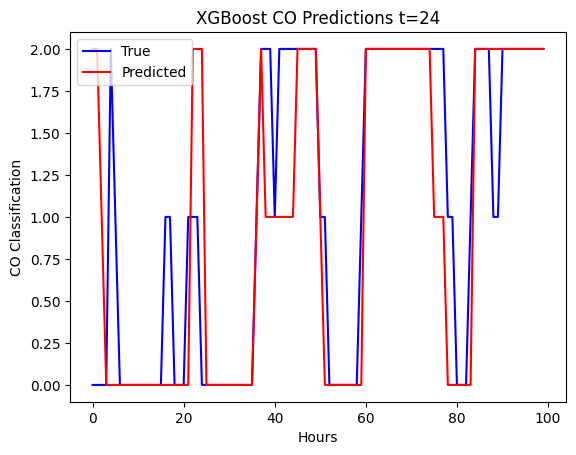

Compared against baseline naive t=24:
(array([0, 1, 2]), array([311, 250, 451]))

total=988 correct=567 naive accuracy=57.39%
confusion matrix (vertical axis=true, horizontal=predicted):
[[185  64  58]
 [ 66  82  93]
 [ 36 104 300]]


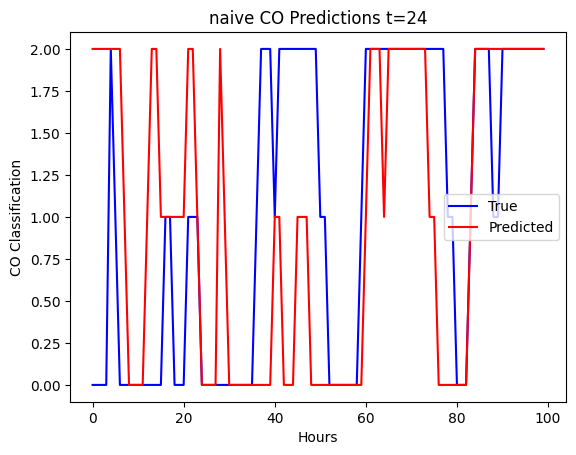

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\1267433456.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


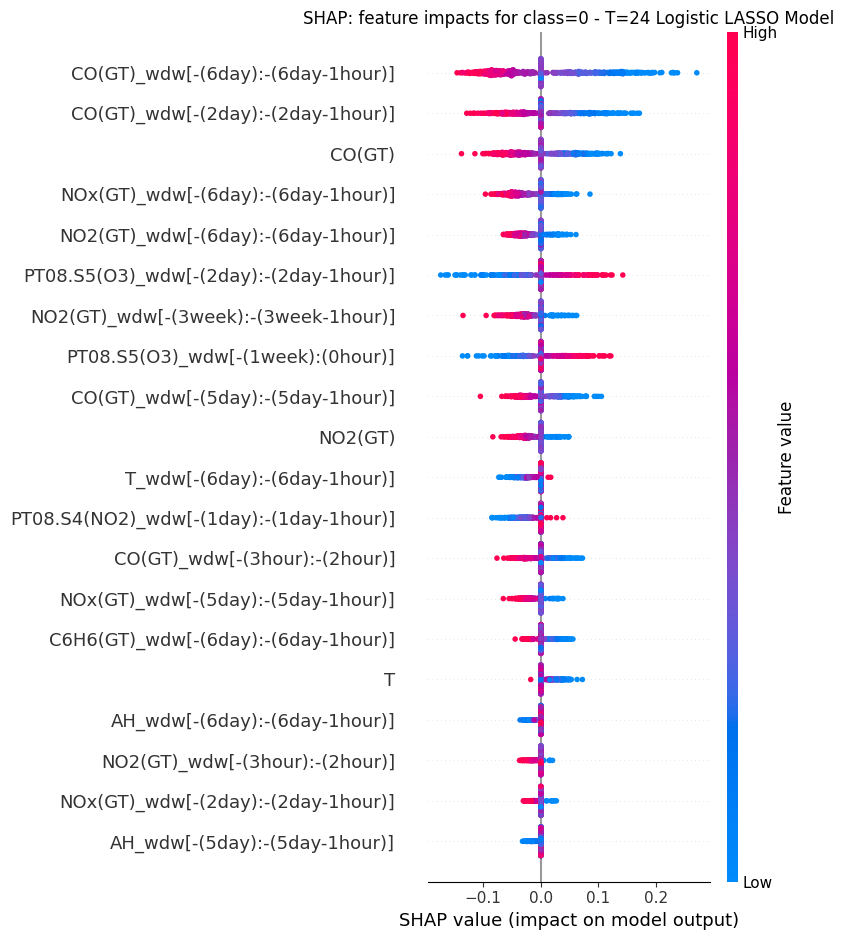

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\1267433456.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


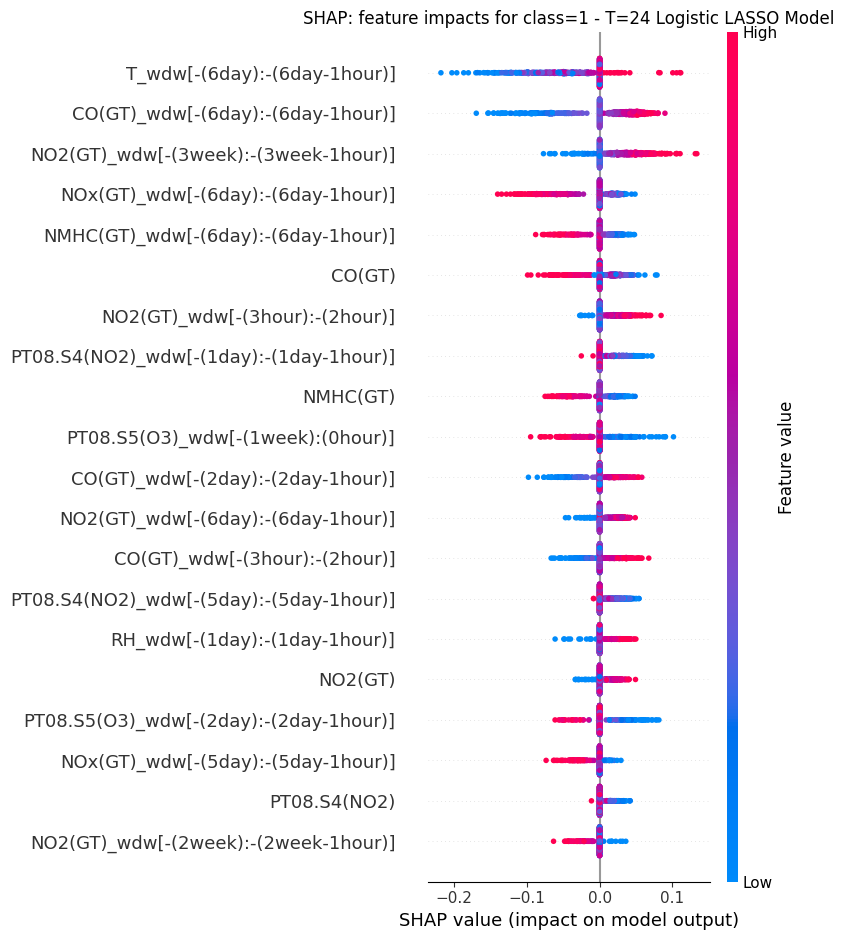

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\1267433456.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


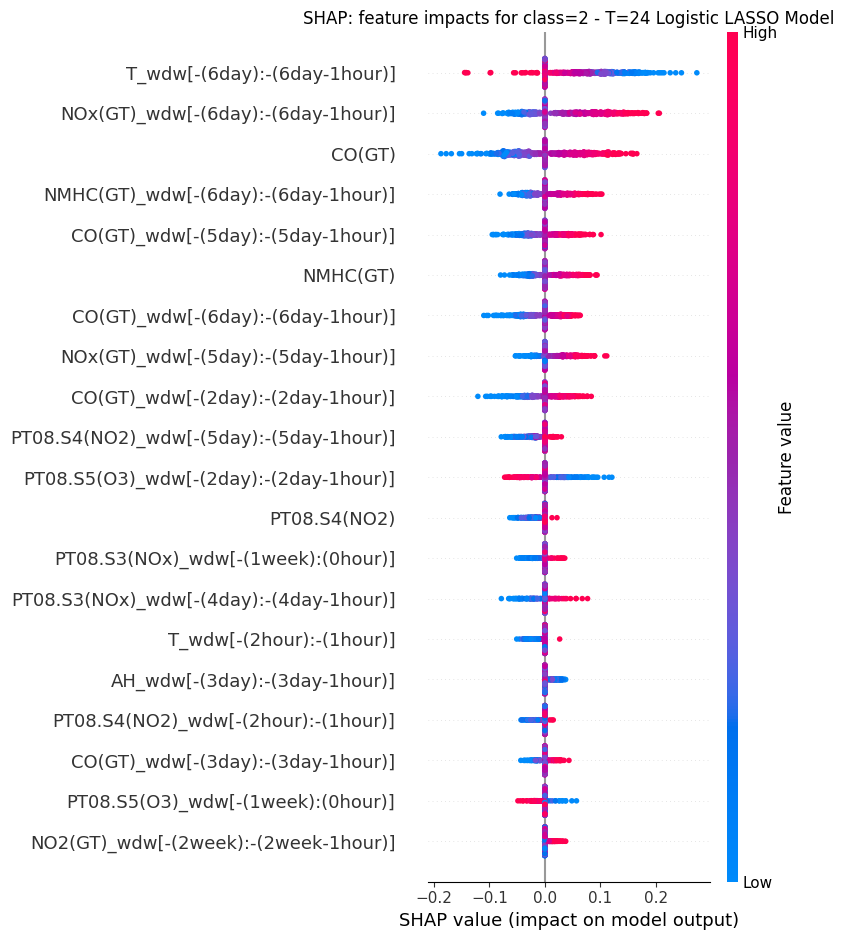

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\1267433456.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


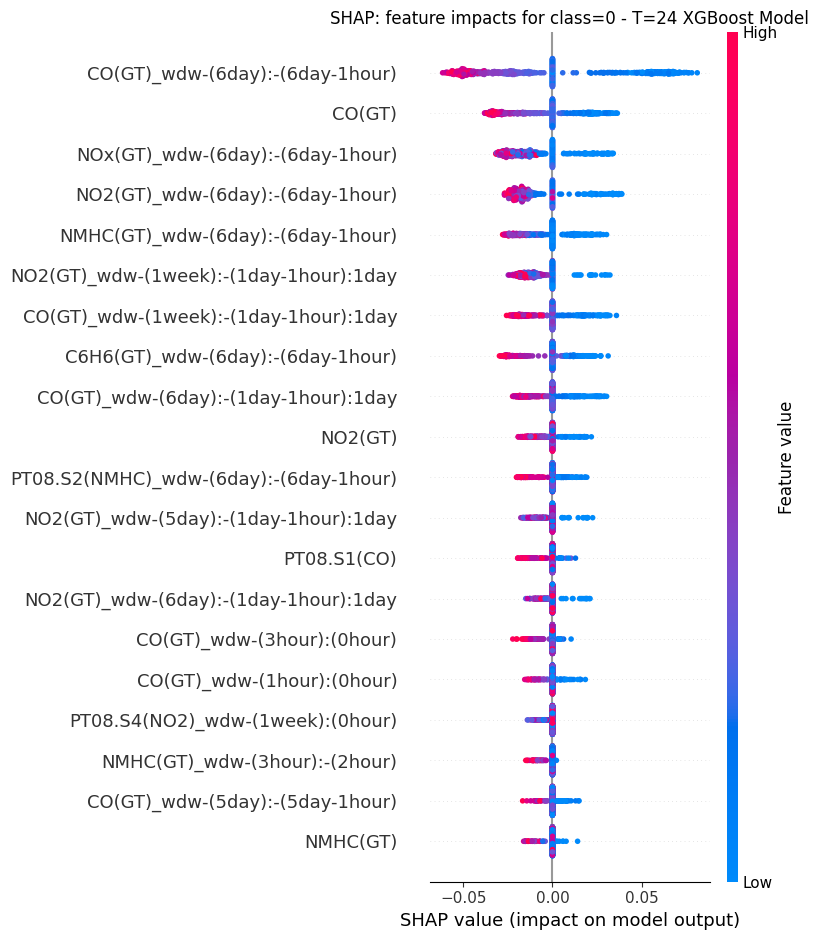

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\1267433456.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


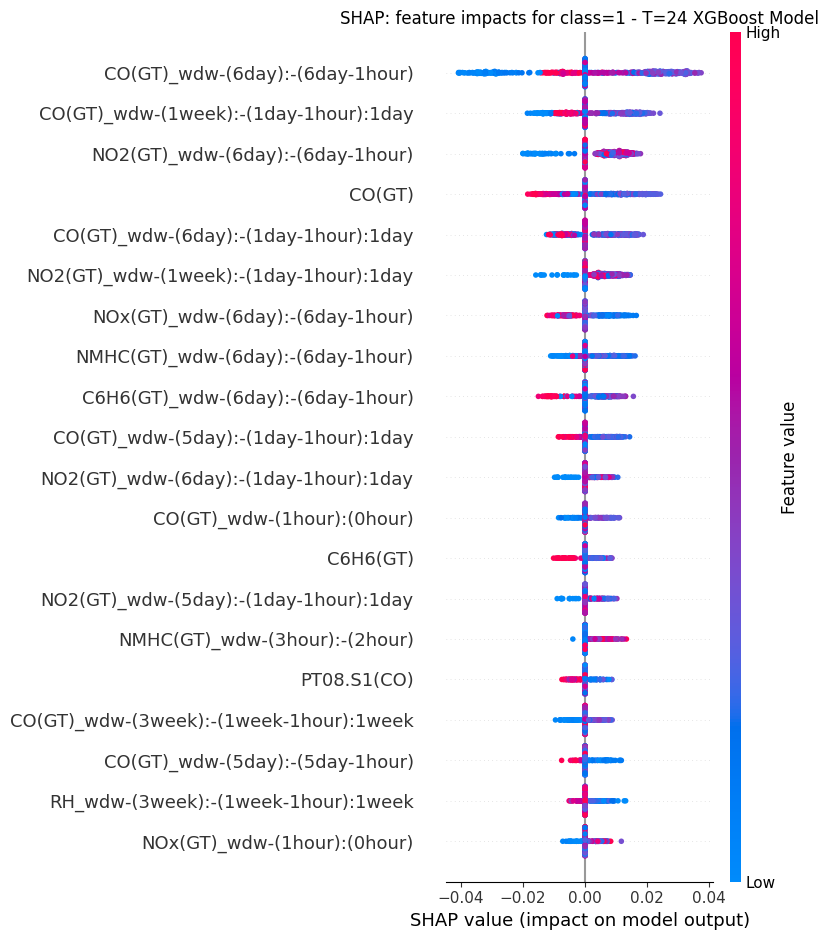

C:\Users\darre\AppData\Local\Temp\ipykernel_31980\1267433456.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


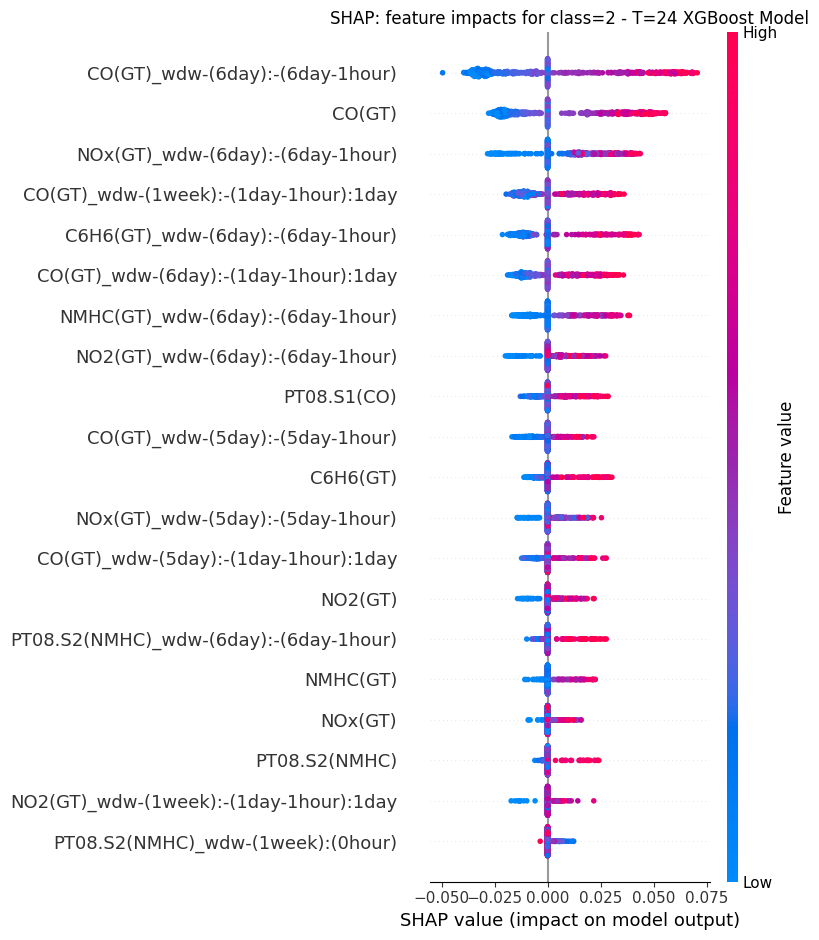

In [ ]:
# Testing on time horizon 24
t = 24
t_temporal_prediction(best_logistic, t, test_proportion, X_nontest_1, y_nontest_1, "Logistic LASSO")
t_temporal_prediction(best_xgb, t, test_proportion, X_nontest_2, y_nontest_2, "XGBoost")
shap_values_log_24 = shap_graph(best_logistic, X_test_1, X_nontest_1, f"T={t} Logistic LASSO Model")
shap_values_xgb_24 = shap_graph(best_xgb, X_test_2, X_nontest_2, f"T={t} XGBoost Model")

Logistic LASSO Model performance t=24
total=334 correct=205 Logistic LASSO accuracy=61.38%
confusion matrix (vertical axis=true, horizontal=predicted):
[[114  24  26]
 [ 14  36  41]
 [  5  19  55]]


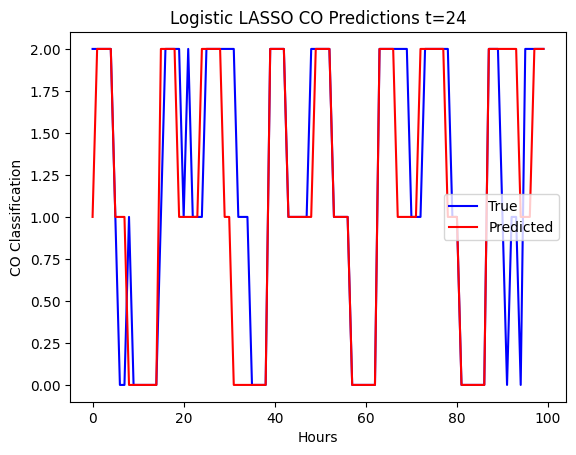

Compared against baseline naive t=24:
(array([0, 1, 2]), array([145,  76, 137]))

total=334 correct=190 naive accuracy=56.89%
confusion matrix (vertical axis=true, horizontal=predicted):
[[91 21 31]
 [16 24 31]
 [14 31 75]]


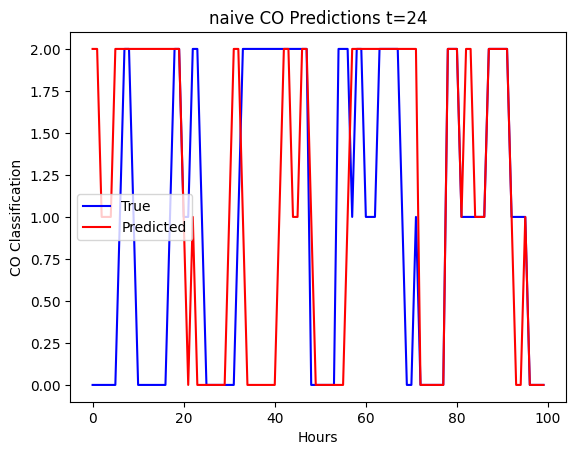

XGBoost Model performance t=24
total=334 correct=194 XGBoost accuracy=58.08%
confusion matrix (vertical axis=true, horizontal=predicted):
[[114  25  25]
 [ 11  25  55]
 [  7  17  55]]


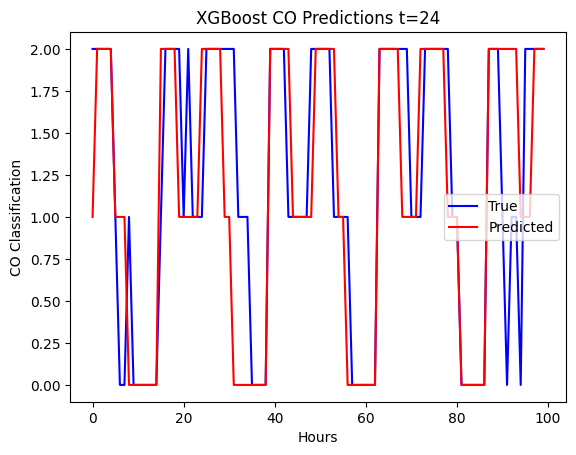

Compared against baseline naive t=24:
(array([0, 1, 2]), array([145,  76, 137]))

total=334 correct=190 naive accuracy=56.89%
confusion matrix (vertical axis=true, horizontal=predicted):
[[91 21 31]
 [16 24 31]
 [14 31 75]]


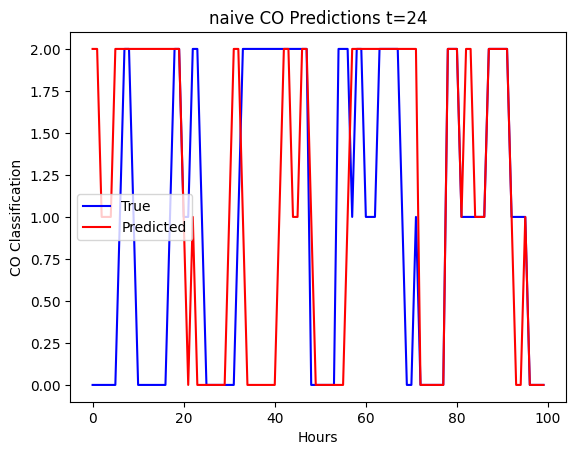

In [52]:
t=24
t_temporal_prediction(best_logistic, t, test_proportion, X_test_1, y_test_1, "Logistic LASSO")
t_temporal_prediction(best_xgb, t, test_proportion, X_test_2, y_test_2, "XGBoost")

#### Feature Extraction and Testing

In [53]:
feature_names = X_train_1.columns.tolist()
shap_abs = np.abs(shap_values_log_1)
shap_log = shap_abs.mean(axis=0)  
importance = shap_log.mean(axis=1) 
df_log = pd.DataFrame({
    "feature": feature_names,
    "importance": importance
}).sort_values("importance", ascending=False)


feature_names = X_train_2.columns.tolist()
shap_xgb = np.mean(np.abs(shap_values_xgb_1), axis=2)
importance = np.mean(np.abs(shap_xgb), axis=0)
df_xgb = pd.DataFrame({
    "feature": feature_names,
    "importance": importance
}).sort_values("importance", ascending=False)

print(df_log)
print(df_xgb)

                                             feature  importance
4                                      PT08.S2(NMHC)    0.119587
0                                             CO(GT)    0.098925
5                                            NOx(GT)    0.062090
1                                        PT08.S1(CO)    0.037115
16                    C6H6(GT)_wdw[-(1hour):(0hour)]    0.036396
..                                               ...         ...
305  PT08.S3(NOx)_wdw[-(3week):-(1week-1hour):1week]    0.000000
307  PT08.S4(NO2)_wdw[-(3week):-(1week-1hour):1week]    0.000000
309             T_wdw[-(3week):-(1week-1hour):1week]    0.000000
310            RH_wdw[-(3week):-(1week-1hour):1week]    0.000000
311            AH_wdw[-(3week):-(1week-1hour):1week]    0.000000

[312 rows x 2 columns]
                                        feature  importance
0                                        CO(GT)    0.060845
3                                      C6H6(GT)    0.049378
4               

In [54]:
top20_features_log = df_log.head(20)["feature"].tolist()
top30_features_log = df_log.head(30)["feature"].tolist()

top20_features_xgb = df_xgb.head(20)["feature"].tolist()
top30_features_xgb = df_xgb.head(30)["feature"].tolist()